# Fallback - Insert Retention Scores NFL-49ers
* StellarAlgo Data Science
* Ryan Kazmerik, Grant Donst
* Sept 29, 2022

In [112]:
import boto3
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *
from shared_utilities import helpers

In [113]:
if not boto3.DEFAULT_SESSION:
    ! aws sso login --profile Stellaralgo-DataScienceAdmin
    session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

In [114]:
LKUPCLIENTID = "95"
DBNAME = "stlrnfl49ers"
ENV = "prod-app"
SCORINGYEAR = 2021

In [115]:
df = helpers.get_retention_dataset(
    cluster = ENV,
    database = DBNAME,
    lkupclientid = LKUPCLIENTID,
    start_year = 2010,
    end_year = 2022
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


(72248, 24)

In [116]:
df.year.value_counts()

2021    18261
2018    18168
2022    18014
2019    17805
Name: year, dtype: int64

In [117]:
df.head()

,lkupclientid,clientcode,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,...,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer
0,95,NFL49ERS,18186,2018,Full Season,2500.0,2018-12-23,0.94,101,3650,...,0,0,4,0.00,0.00,0.00,Male,0,0,1
1,95,NFL49ERS,18186,2021,Full Season,2980.0,2022-01-02,0.94,104,3650,...,1,0,11,0.00,0.00,0.00,Male,0,0,1
2,95,NFL49ERS,18227,2019,Full Season,2214.0,2020-01-19,1.00,120,4380,...,0,0,0,0.00,0.00,0.00,Male,0,0,1
3,95,NFL49ERS,18379,2022,Full Season,1450.0,1970-01-01,0.00,303,3650,...,1,0,3,0.34,0.09,0.25,Male,0,0,0
4,95,NFL49ERS,18381,2018,Full Season,5692.0,2018-12-23,0.38,203,1825,...,1,1,32,0.00,0.00,0.00,Unknown,0,0,1


### We should specify the features used in our model:

In [118]:
# choose the features for the stellar base retention model
features = [
    "recentdate",
	"clientcode",
	"dimcustomermasterid",
	"lkupclientid",
	"productgrouping",
	"year",
	"attendancepercent",
	"disttovenue",
    "inperson_contact",
	"missed_games_1",
	"missed_games_2",
	"missed_games_over_2",
	"recency",
	"source_tenure",
	"totalspent",
	"isnextyear_buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] < SCORINGYEAR]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (30577, 16)
Unseen Data For Predictions: (5396, 16)



In [119]:
print(df_dataset.year.value_counts())

2018    18168
2019    17805
Name: year, dtype: int64


### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [120]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentdate"
    ],
    ignore_features=[
        "clientcode",
		"dimcustomermasterid",
		"lkupclientid",
		"productgrouping",
		"year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
		"disttovenue",
        "inperson_contact",
		"missed_games_1",
		"missed_games_2",
		"missed_games_over_2",
		"recency",
		"source_tenure",
		"totalspent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [121]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","rf","xgboost"],
    n_select=5,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9431,0.6513,1.0000,0.9431,0.9707,0.0000,0.0000,0.0750
gbc,Gradient Boosting Classifier,0.9426,0.7142,0.9936,0.9480,0.9703,0.1450,0.1975,1.1650
lightgbm,Light Gradient Boosting Machine,0.9389,0.7019,0.9887,0.9486,0.9683,0.1510,0.1814,0.2030
xgboost,Extreme Gradient Boosting,0.9329,0.6948,0.9811,0.9495,0.9650,0.1552,0.1688,0.4000
rf,Random Forest Classifier,0.9185,0.6503,0.9636,0.9506,0.9571,0.1492,0.1506,0.3770


In [122]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9173,0.6515,0.9629,0.9501,0.9565,0.1334,0.1346
1,0.9146,0.6497,0.9596,0.9503,0.9549,0.1391,0.1397
2,0.9173,0.6704,0.9641,0.9490,0.9565,0.1210,0.1225
3,0.9192,0.6114,0.9661,0.9491,0.9575,0.1256,0.1277
4,0.9188,0.6369,0.9641,0.9505,0.9573,0.1496,0.1512
5,0.9177,0.6717,0.9596,0.9534,0.9565,0.1924,0.1927
6,0.9223,0.6244,0.9698,0.9489,0.9592,0.1267,0.1303
7,0.9200,0.6849,0.9633,0.9524,0.9578,0.1822,0.1833
8,0.9165,0.6352,0.9637,0.9486,0.9561,0.1128,0.1142


### Let's load in our 2021 season data and get retention scores using the model:

In [123]:
df_inference = df.loc[df["year"] >= SCORINGYEAR]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(36275, 16)

In [124]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.4751,0.7514,1.0000,0.4751,0.6441,0.0000,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8459,0.9107,0.9738,0.7656,0.8572,0.6950,0.7189


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8251,0.9348,0.9713,0.7410,0.8407,0.6544,0.6842


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8406,0.9050,0.9438,0.7715,0.8490,0.6837,0.6993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9169,0.9657,0.8714,0.9494,0.9087,0.8326,0.8352


### We can create some histograms to visualize each model distribution:

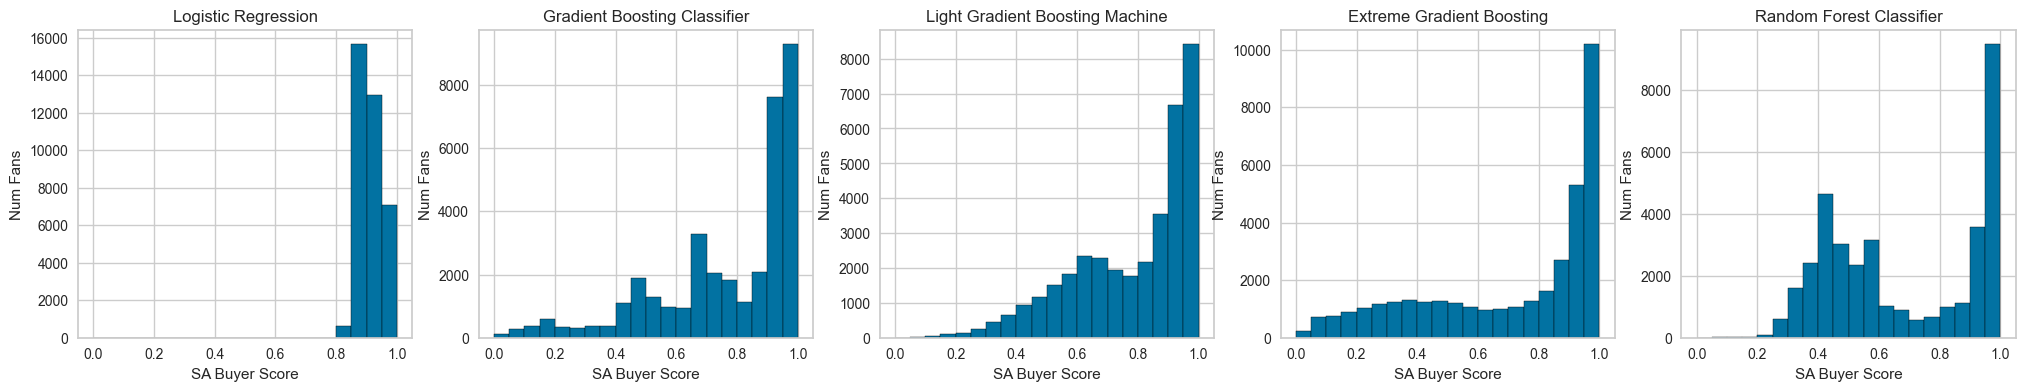

In [125]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 5, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [126]:
for idx, model in enumerate(models):
    print(models[idx]["predictions"]["Label"].value_counts())


1    36274
0        1
Name: Label, dtype: int64
1    21917
0    14262
Name: Label, dtype: int64
1    22589
0    13685
Name: Label, dtype: int64
1    21080
0    15149
Name: Label, dtype: int64
0    20454
1    15816
Name: Label, dtype: int64


### Select the model you would like to use for updating scores:

In [127]:
selected_model = "Light Gradient Boosting Machine"

for model in models:
    if model["name"] == selected_model:
        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36274 entries, 1 to 72247
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   recentdate           36274 non-null  datetime64[ns]
 1   clientcode           36274 non-null  object        
 2   dimcustomermasterid  36274 non-null  int64         
 3   lkupclientid         36274 non-null  int64         
 4   productgrouping      36274 non-null  object        
 5   year                 36274 non-null  int64         
 6   attendancepercent    36274 non-null  float64       
 7   disttovenue          36274 non-null  float64       
 8   inperson_contact     36274 non-null  int64         
 9   missed_games_1       36274 non-null  object        
 10  missed_games_2       36274 non-null  object        
 11  missed_games_over_2  36274 non-null  object        
 12  recency              36274 non-null  int64         
 13  source_tenure        36274 non-

### A look at the retention scores:

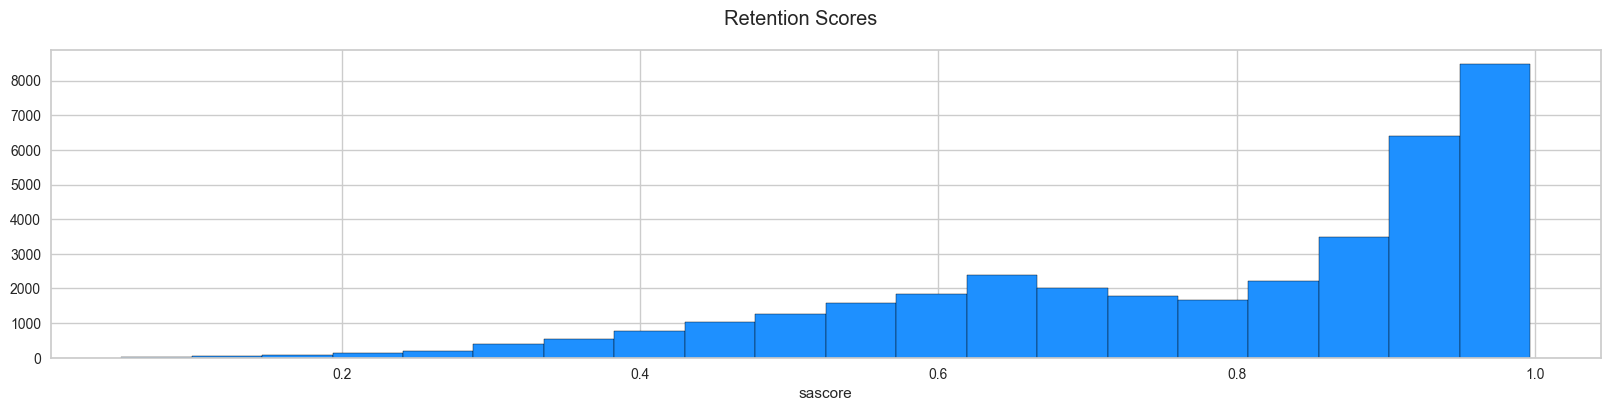

In [128]:
fig, ax1 = plt.subplots(1)
fig.suptitle('Retention Scores')
ax1.hist(df_scores['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('sascore')

fig.figure.set_figwidth(20)

### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [129]:
CONN = helpers.get_redshift_connection(ENV, DBNAME)

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


### Insert the scores into the customerretentionscores table in RedShift:

In [130]:
cur = CONN.cursor()

batch_size = 1000
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {DBNAME} ({LKUPCLIENTID})")

fields = f"""
INSERT INTO {DBNAME}.dw.customerretentionscores (
    attendancePercentage,
    dimcustomermasterid,
    scoredate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonyear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancepercent)},
                {str(row.dimcustomermasterid)},
                '{str(datetime.now().strftime("%Y-%m-%d"))}',
                {str(row.lkupclientid)},
                '{str(row.recentdate)}',
                '{str(row.productgrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    cur.execute(insert_statement)
    CONN.commit()

    count = cur.rowcount
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 36270 NEW RETENTION SCORES TO DATABASE: stlrnfl49ers (95)
 > INSERTED BATCH 1 : ROWS 1 - 100
 > INSERTED BATCH 2 : ROWS 101 - 200
 > INSERTED BATCH 3 : ROWS 201 - 300
 > INSERTED BATCH 4 : ROWS 301 - 400
 > INSERTED BATCH 5 : ROWS 401 - 500
 > INSERTED BATCH 6 : ROWS 501 - 600
 > INSERTED BATCH 7 : ROWS 601 - 700
 > INSERTED BATCH 8 : ROWS 701 - 800
 > INSERTED BATCH 9 : ROWS 801 - 900
 > INSERTED BATCH 10 : ROWS 901 - 1000
 > INSERTED BATCH 11 : ROWS 1001 - 1100
 > INSERTED BATCH 12 : ROWS 1101 - 1200
 > INSERTED BATCH 13 : ROWS 1201 - 1300
 > INSERTED BATCH 14 : ROWS 1301 - 1400
 > INSERTED BATCH 15 : ROWS 1401 - 1500
 > INSERTED BATCH 16 : ROWS 1501 - 1600
 > INSERTED BATCH 17 : ROWS 1601 - 1700
 > INSERTED BATCH 18 : ROWS 1701 - 1800
 > INSERTED BATCH 19 : ROWS 1801 - 1900
 > INSERTED BATCH 20 : ROWS 1901 - 2000
 > INSERTED BATCH 21 : ROWS 2001 - 2100
 > INSERTED BATCH 22 : ROWS 2101 - 2200
 > INSERTED BATCH 23 : ROWS 2201 - 2300
 > INSERTED BATCH 24 : ROWS 2301 - 2400
 >